In [ ]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.exc import SQLAlchemyError
from ml_functions import *
from sklearn.metrics import accuracy_score, recall_score
from db_queries import username, password, dsn, dbhostname, service_name, dbtables, querys
from table_functions import *
import mlflow
import mlflow.pyfunc
import xgboost as xgb

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# DGM id - oni id_dmc
# DGM dmc - MEB_DMC dmc_casting

def read_last_meb_dgm(last_id = 0):

    data = {}
    if last_id:
        query = f"""SELECT *
            FROM (
                SELECT
                    t.*,
                    ROW_NUMBER() OVER (PARTITION BY DMC ORDER BY ID DESC) AS rn
                FROM
                    Z3DMC.MEB_DGM t
            ) subquery
            WHERE rn = 1
            AND id > {last_id}"""

    else:
        query = """SELECT *
            FROM (
                SELECT *
                FROM Z3DMC.MEB_DGM
                ORDER BY ID DESC
            )
            WHERE ROWNUM = 1
            """
    
    try:
        sqlalchemy_engine="oracle+cx_oracle://"+username+":"+password+"@"+dbhostname+"/?service_name="+service_name
        engine = sqlalchemy.create_engine(sqlalchemy_engine, arraysize=1000)
        data.update({'MEB_DGM': pd.read_sql(query, engine)})
    except SQLAlchemyError as e:
        print(e)
    
    data['MEB_DGM'].drop(columns=['timestamp','data_znakowania','data_odlania', 'metal_level', 'metal_pressure', 'max_press_kolbenhub', 'oni_temp_curr_f2'], inplace= True)

    last_id = data['MEB_DGM'].id.max()
    
    return data, last_id

def check_if_meb_base(data):
    size0 = data['MEB_DGM'].shape[0]
    data['MEB_DGM'].dmc = data['MEB_DGM']['dmc'].str.strip()
    data['MEB_DGM'] = data['MEB_DGM'][(data['MEB_DGM']['nr_dgm'].between(8, 10)) & (data['MEB_DGM']['dmc'].apply(lambda x: len(str(x)) == 21))]
    size1 = data['MEB_DGM'].shape[0]
    if data['MEB_DGM'].empty:
        print('There are not MEB_BASE+ part produced since last time')
        return 1
    else:
        print(f"{size1} of {size0} are MEB Base+ parts")
        return data

def read_oni(data):
    id_list = list(data['MEB_DGM'].id)
    ids_ranges = [id_list[x:x+500] for x in range(0, len(id_list), 500)]
    ids_ranges_tuples = [tuple(sublist) for sublist in ids_ranges]

    result_df = pd.DataFrame()
    try:
        sqlalchemy_engine="oracle+cx_oracle://"+username+":"+password+"@"+dbhostname+"/?service_name="+service_name
        engine = sqlalchemy.create_engine(sqlalchemy_engine, arraysize=1000)

        for ids in ids_ranges_tuples:
            query = f"""SELECT ID_DMC, CIRCUIT_NR, 
                    MAX(ASSIGMENT) AS ASSIGMENT, 
                    MAX(FLOW) AS FLOW, 
                    MAX(SET_POINT) AS SET_POINT,
                    MAX(START_DELAY) AS START_DELAY,
                    MAX(TEMP) AS TEMP,
                    MAX(WORKING_MODE) AS WORKING_MODE
                FROM Z3DMC.ONI_CIRCUITS
                WHERE ID_DMC IN {ids}
                GROUP BY ID_DMC, CIRCUIT_NR
                ORDER BY ID_DMC
                """
    
            df = pd.read_sql(query, engine)
            result_df = pd.concat([result_df, df], ignore_index=True)

            
    except SQLAlchemyError as e:
        print(e)

    data.update({'ONI_CIRCUITS': result_df})
    
    return data

def combine_into_one_table(data):
    data['ONI_CIRCUITS'].drop(columns = ['assigment', 'working_mode', 'set_point'], inplace = True)
    oni_circuits = data['ONI_CIRCUITS'].pivot(index='id_dmc', columns='circuit_nr', values=['flow', 'start_delay', 'temp'])
    oni_circuits.columns = oni_circuits.columns.map('{0[0]}_{0[1]}'.format) 
    oni_circuits.reset_index(inplace=True)
    final_table = data['MEB_DGM'].copy()
    final_table = final_table.merge(oni_circuits, left_on='id', right_on='id_dmc', how='inner')

    return final_table

# Save value to a text file
def save_id_to_file(value, filename='pipeline_files/id.txt'):
    with open(filename, 'w') as file:
        file.write(str(value))

# Read value from a text file
def read_id_from_file(filename='pipeline_files/id.txt'):
    try:
        with open(filename, 'r') as file:
            return file.read().strip()
    except FileNotFoundError:
        return None
    
def stats_about_predictions(predictions_, y_true_, y_classes_pred):

    print(f"Number of checked parts in this part: {len(predictions_)}")
    print(f"Number of NOK parts: {np.sum(y_classes_pred == 1)}")
    print(f"Percent of NOK parts in this part: {np.sum(y_classes_pred == 1) / len(predictions_)}")

    fig_ = distribution_of_probability_plot(predictions_, y_true_)

def predict_status(model_, data, y_true, threshold = 0.925):

    dmatrix = xgb.DMatrix(data.drop(columns = ['id','our_final_status', 'data_odlania', 'nr_dgm']))
    predictions = model_.predict(dmatrix)
    y_pred = np.where(predictions < threshold, 0, 1)
    #print(y_pred)

    stats_about_predictions(predictions, y_true, y_pred)
    return y_pred



## Loading data from last id

In [ ]:
dgm, id_max = read_last_meb_dgm(1474000)          # 1474000    1494449

In [ ]:
dgm = check_if_meb_base(dgm)

In [ ]:
dgm_oni = read_oni(dgm)

In [ ]:
dgm_oni['ONI_CIRCUITS'].shape

In [ ]:
final_tab = combine_into_one_table(dgm_oni)

In [ ]:
fin_dgm9 = final_tab[final_tab['nr_dgm']==9]
fin_dgm10 = final_tab[final_tab['nr_dgm']==10]

In [ ]:
columns_needed = pd.read_csv('./pipeline_files/column_names.csv', header=None)[0].tolist()

In [ ]:
columns_to_drop = final_tab.columns.difference(columns_needed)
final_tab = final_tab.drop(columns=columns_to_drop)

In [ ]:
final_tab.keys()

In [ ]:
# Load the XGBoost model
model = xgb.Booster(model_file=r'C:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\src\final_model\model\model.xgb')

In [ ]:
dmatrix = xgb.DMatrix(final_tab)
predictions = model.predict(dmatrix)
y_pred = np.where(predictions < 0.9, 0, 1)
print(y_pred)

In [ ]:
np.sum(y_pred == 1)

## From October predictions

In [ ]:
model_dgm9_and_10 = xgb.Booster(model_file=r'C:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\src\final_model\model\model.xgb')

In [ ]:
from_october = load_csv('test_data_from_october.csv')
fin_dgm9 = from_october[from_october['nr_dgm']==9]
fin_dgm10 = from_october[from_october['nr_dgm']==10]

In [ ]:
y_dgm9 = fin_dgm9['our_final_status']
y_dgm10 = fin_dgm10['our_final_status']

In [ ]:
y_october = from_october['our_final_status']

In [ ]:
y_pred_9_10_model_9_10 = predict_status(model_dgm9_and_10, from_october, y_october)
# predict_status(model, fin_dgm9, y_dgm9)
# predict_status(model, fin_dgm10, y_dgm10)

In [ ]:
conf69 = create_confusion_matrix(y_october, y_pred_9_10_model_9_10)

## Models for dgm9 and dgm10

In [ ]:
model_dgm9 = xgb.Booster(model_file=r'c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\src\mlruns/833265486894331728/127032651b42435ea75d46b13e60c537/artifacts/model/model.xgb')
model_dgm10 = xgb.Booster(model_file=r'c:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\src\mlruns/434245836703521692/50856305a5a942f5ac6526184e71a85a/artifacts/model/model.xgb')
model_dgm9_and_10 = xgb.Booster(model_file=r'C:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\src\final_model\model\model.xgb')

In [ ]:
from_october_dgm9 = load_csv('test_dgm9_9_from_october.csv')
from_october_dgm10 = load_csv('test_dgm10_10_from_october.csv')

In [ ]:
y_dgm9 = from_october_dgm9['our_final_status']
y_dgm10 = from_october_dgm10['our_final_status']

### DGM9

#### Predict

Number of checked parts in this part: 5230
Number of NOK parts: 13
Percent of NOK parts in this part: 0.00248565965583174


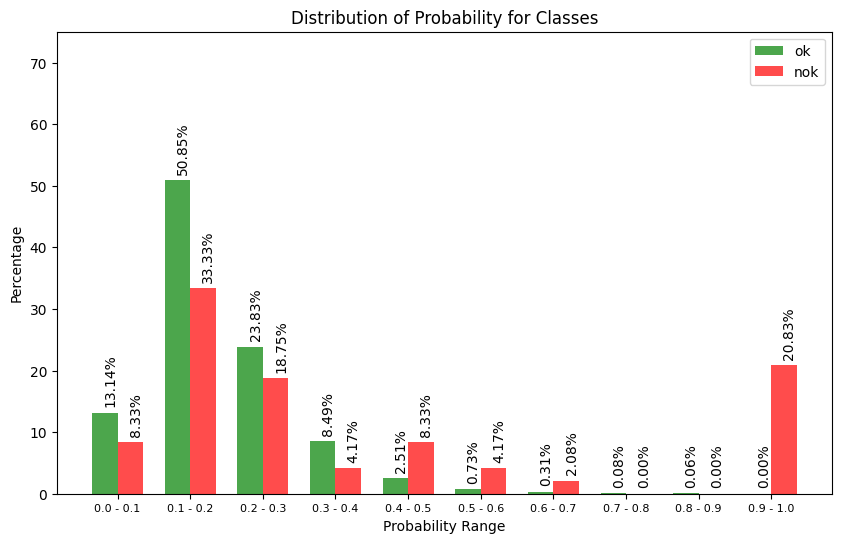

In [42]:
#predict_status(model, from_october, y_october)
y_pred_dgm9 = predict_status(model_dgm9, from_october_dgm9, y_dgm9, threshold=0.8)

In [ ]:
y_pred_dgm9_from_model_9_10 = predict_status(model_dgm9_and_10, from_october_dgm9, y_dgm9, threshold=0.9)

#### Matrix

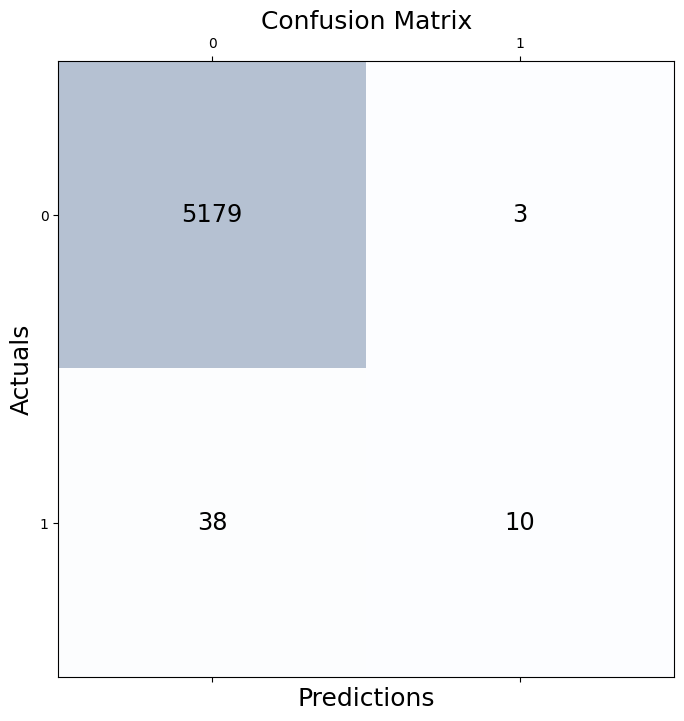

In [43]:
conf_matrix_dgm9 = create_confusion_matrix(y_dgm9, y_pred_dgm9)

In [ ]:
conf_matrix_dgm9_from_model_9_10 = create_confusion_matrix(y_dgm9, y_pred_dgm9_from_model_9_10)

### DGM10

#### Predict

In [ ]:
y_pred_dgm10 = predict_status(model_dgm10, from_october_dgm10, y_dgm10)

In [ ]:
y_pred_dgm10_from_model_9_10 = predict_status(model_dgm9_and_10, from_october_dgm10, y_dgm10)

#### Matrix

In [ ]:
conf_matrix_dgm10 = create_confusion_matrix(y_dgm10, y_pred_dgm10)

In [ ]:
conf_matrix_dgm10_from_model_9_10 = create_confusion_matrix(y_dgm10, y_pred_dgm10_from_model_9_10)

In [ ]:
print(fin_dgm9.shape)
print(from_october_dgm9.shape)
print(fin_dgm10.shape)
print(from_october_dgm10.shape)

## Rozłożenie detali NOK w czasie

In [ ]:
from main import *

In [ ]:
def combine_final_table_dgm8(data_tmp):

    data = data_tmp.copy()
    # usuwanie znaków białych z DMC[MEB_DGM] i DMC_CASTING[MEB_DMC]
    data['MEB_DMC'].dmc_casting = data['MEB_DMC']['dmc_casting'].str.strip()
    data['MEB_DGM'].dmc = data['MEB_DGM']['dmc'].str.strip()

    # usuwanie z meb_dmc wierszy z 'WORKPIECE NIO' w kodzie DMC
    data['MEB_DMC'] = data['MEB_DMC'][~data['MEB_DMC']['dmc'].str.contains('WORKPIECE', case=False, na=False)]

    # wybieranie rekordów dla MEB+ 
    data['MEB_DGM'] = data['MEB_DGM'][(data['MEB_DGM']['nr_dgm'].between(8, 8)) & (data['MEB_DGM']['dmc'].apply(lambda x: len(str(x)) == 21))]
    # usunięcie anomalii z MEB_DMC
    data['MEB_DMC'] = data['MEB_DMC'][data['MEB_DMC']['dmc'].str[:3] == '0MH']

    # łączę tabele MEB_KO i MEB_KO_DGM z tabelami MEB_KO_STREFA/RODZAJ
    data['MEB_KO'] = data['MEB_KO'].merge(data['MEB_KO_STREFA'], left_on='nok_strefa', right_on='indeks', how='inner')
    data['MEB_KO'].drop(columns=['indeks'], inplace=True)
    data['MEB_KO'] = data['MEB_KO'].merge(data['MEB_KO_RODZAJ'], left_on='nok_rodzaj', right_on='indeks', how='inner')
    data['MEB_KO'].drop(columns=['indeks'], inplace=True)
    data['MEB_KO_DGM'] = data['MEB_KO_DGM'].merge(data['MEB_KO_STREFA'], left_on='nok_strefa', right_on='indeks', how='inner')
    data['MEB_KO_DGM'].drop(columns=['indeks'], inplace=True)
    data['MEB_KO_DGM'] = data['MEB_KO_DGM'].merge(data['MEB_KO_RODZAJ'], left_on='nok_rodzaj', right_on='indeks', how='inner')
    data['MEB_KO_DGM'].drop(columns=['indeks'], inplace=True)

    # łączę tabelę MEB_DMC z tabelą MEB_KO
    data['MEB_DMC'] = data['MEB_DMC'].merge(data['MEB_KO'], on='id_dmc', how='left')
    data['MEB_DMC'].drop(columns=['rn'], inplace=True)

    # łączę tabelę MEB_DMC z tabelą MEB_GROB
    data['MEB_DMC'] = data['MEB_DMC'].merge(data['MEB_GROB'], on='id_dmc', how='left')
    data['MEB_DMC'].drop(columns=['rn'], inplace=True)

    # łączę tabelę MEB_DMC z tabelą MEB_KS
    data['MEB_DMC'] = data['MEB_DMC'].merge(data['MEB_KS'], on='id_dmc', how='left')
    data['MEB_DMC'].drop(columns=['rn'], inplace=True)


    final_table = data['MEB_DGM'].copy()
    final_table.drop(columns=['rn'], inplace=True)

    # łączę tabelę MEB_DGM z tabelą MEB_KO_DGM
    final_table = final_table.merge(data['MEB_KO_DGM'], left_on='id', right_on='id_dmc', how='left')
    final_table.drop(columns=['rn'], inplace=True)

    # łączę z tabelą MEB_DGM
    final_table.rename(columns={'id_dmc_x': 'id_dmc'}, inplace=True)

    # łączę tabelę MEB_DMC z ONI_CIRCUITS
    final_table = final_table.merge(data['MEB_DMC'], left_on='dmc', right_on='dmc_casting', how='left', suffixes=('_DGM', '_DMC'))

    final_table.drop(columns=['nok_strefa_DGM', 'nok_rodzaj_DGM', 'status_ko_DGM', 'kod_pola_DGM', 'rodzaj_uszkodzenia_DGM'], inplace=True)
    final_table.rename(columns={'nok_strefa_DMC': 'nok_strefa', 'nok_rodzaj_DMC': 'nok_rodzaj', 
                                'status_ko_DMC': 'status_ko', 'kod_pola_DMC': 'kod_pola', 
                                'rodzaj_uszkodzenia_DMC': 'rodzaj_uszkodzenia'}, inplace=True)
                                
    final_table.drop(index=final_table[(final_table['dmc_DGM'].duplicated(keep=False)) & (~final_table['dmc_casting'].isna())].index, inplace=True)
    final_table.drop(columns = ['part_status'], inplace = True)

    return final_table

def create_final_status_dgm8(final_table_tmp):
    # statusy dmc 2 zostały całkowicie wywalone (jest ich ok. 450)
    # co do statusu szczelności to czasami na to wpływ ma porowatość wynikająca z odlewania,
    # jednak jest dużo błędów wynikających z obróbki czy zepsutej uszczelki

    final_table = final_table_tmp.copy()
    final_table = final_table[~final_table['status'].isin(['4', '5', '7', '8', '10', '11'])]
    final_table['status'] = final_table['status'].replace(['3', '14'], '2')
    final_table = final_table.loc[~final_table['status_ko'].isin([0, 106])]
    final_table = final_table.loc[~final_table['statusszczelnosc'].isin([0, 3])]
    final_table = final_table.loc[~final_table['statusdmc'].isin([0,2])]

    final_table['our_final_status'] = final_table.apply(lambda row: max(int(row['status']), row['status_ko'], row['statusszczelnosc'], row['statusdmc']), axis=1)
    print(final_table['our_final_status'].value_counts())
    final_table.drop(columns=['status', 'status_ko', 'statusszczelnosc', 'statusdmc', 
                              'part_type', 'nrprogramu', 'id_dmc_DGM', 
                              'id_dmc_DGM', 'dmc_DGM', 'product_id', 'line_id', 
                              'dmc_DMC', 'dmc_casting', 'nok_strefa', 'nok_rodzaj'], inplace=True)  # 'nr_dgm' na razie nie kasuje bo testuje dane - JR 25.09

    return final_table

In [ ]:
data_dgm8 = read_data_from_database()

In [ ]:
final_dgm8 = combine_final_table_dgm8(data_dgm8)

In [ ]:
final_dgm8 = create_final_status_dgm8(final_dgm8)
final_dgm8.drop(final_dgm8[final_dgm8['our_final_status'] == 104].index, inplace=True)

In [ ]:
final_dgm8 = categorize_data(final_dgm8)

In [ ]:
test_dgm8 = final_dgm8[(final_dgm8['data_odlania'].dt.month >= 10) & (final_dgm8['data_odlania'].dt.year >= 2023)]
train_dgm8 = final_dgm8.iloc[:-int(test_dgm8.shape[0])]

In [ ]:
columns_to_drop = train_dgm8.columns.difference(columns_needed)
dgm8_train = train_dgm8.drop(columns=columns_to_drop)
dgm8_test = test_dgm8.drop(columns=columns_to_drop)

In [ ]:
ok_samples = dgm8_train[dgm8_train['our_final_status']==0].shape[0]

In [ ]:
ml_data = split_data(dgm8_train, samples= int(ok_samples/2))

In [ ]:
from ml_models.xg_boost import *

clf = xgb_model(*ml_data.values(), run_name_="nn_dgm8")

In [ ]:
model_dgm8 = xgb.Booster(model_file=r"c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/mlruns/558158636042431628/335d53680b064a488c0e6c10dd0cd575/artifacts/model/model.xgb")

In [ ]:
y_dgm8 = dgm8_test['our_final_status']

In [ ]:
dmatrix = xgb.DMatrix(dgm8_test.drop(columns = ['our_final_status']))
predictions = model_dgm8.predict(dmatrix)
y_dgm8_pred = np.where(predictions < 0.9, 0, 1)

In [ ]:
fig1 = create_confusion_matrix(y_dgm8, y_dgm8_pred)